In [1]:
from trainer import train_vae
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from model import VAE
import os
from utils import *
from torch.utils.data import DataLoader, TensorDataset
import itertools


In [2]:
# --- Flexible dataset loading ---
# Either pass a path manually, or automatically find the Samson.mat file
dataset_dir = os.getenv("HSI_DATA_DIR", "./dataset")  # default relative folder
default_file = "Samson.mat"
file_path = os.path.join(dataset_dir, default_file)

if not os.path.exists(file_path):
    raise FileNotFoundError(
        f"Could not find {file_path}. "
        "Set HSI_DATA_DIR env var or update dataset_dir."
    )

# --- Load HSI and tensors ---
hsi, _, _ = load_HSI(file_path)
data = torch.from_numpy(hsi.get_spectra()).float()      # hyperspectral observations
n_sources = 3

print(f"Loaded HSI from: {file_path}")
print(f"Spectra shape: {data.shape}, n_sources: {n_sources}")

data_np=np.array(data)
dataset = TensorDataset(torch.from_numpy(data_np).float())

batch_size = 32  

train_size = int(len(dataset))

train_dataset = dataset

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  
    num_workers=2,
    drop_last=True
)

Loaded HSI from: ./dataset/Samson.mat
Spectra shape: torch.Size([9025, 156]), n_sources: 3


/var/folders/2w/rx5dw8494bg175k6ql3n37dw0000gn/T/ipykernel_55164/1564294221.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  data_np=np.array(data)


In [3]:
device = torch.device("cpu")
vae = VAE(nb_channels=156, n_sources=3)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
train_losses = train_vae(vae, train_loader, epochs=100, device=device)

/opt/anaconda3/envs/AI/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01 | Train: 0.137441 | Recon(last): 0.082437 | KL(last): 4.028986 | LR: 1.00e-03
Epoch 02 | Train: 0.047457 | Recon(last): 0.029964 | KL(last): 4.654783 | LR: 1.00e-03
Epoch 03 | Train: 0.029237 | Recon(last): 0.026778 | KL(last): 4.998765 | LR: 1.00e-03
Epoch 04 | Train: 0.025612 | Recon(last): 0.023515 | KL(last): 5.087278 | LR: 1.00e-03
Epoch 05 | Train: 0.024186 | Recon(last): 0.021776 | KL(last): 4.958048 | LR: 1.00e-03
Epoch 06 | Train: 0.022430 | Recon(last): 0.026507 | KL(last): 5.011436 | LR: 1.00e-03
Epoch 07 | Train: 0.021800 | Recon(last): 0.020700 | KL(last): 5.258532 | LR: 1.00e-03
Epoch 08 | Train: 0.020821 | Recon(last): 0.018656 | KL(last): 5.561012 | LR: 1.00e-03
Epoch 09 | Train: 0.020490 | Recon(last): 0.019696 | KL(last): 5.761147 | LR: 1.00e-03
Epoch 10 | Train: 0.020185 | Recon(last): 0.022163 | KL(last): 5.395576 | LR: 1.00e-03
Epoch 11 | Train: 0.019318 | Recon(last): 0.018857 | KL(last): 5.833768 | LR: 1.00e-03
Epoch 12 | Train: 0.019262 | Recon(last): 0

In [6]:
torch.save(vae.state_dict(), "vae_weights.pth")

/var/folders/2w/rx5dw8494bg175k6ql3n37dw0000gn/T/ipykernel_55164/330578185.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  E_np = np.array(E)


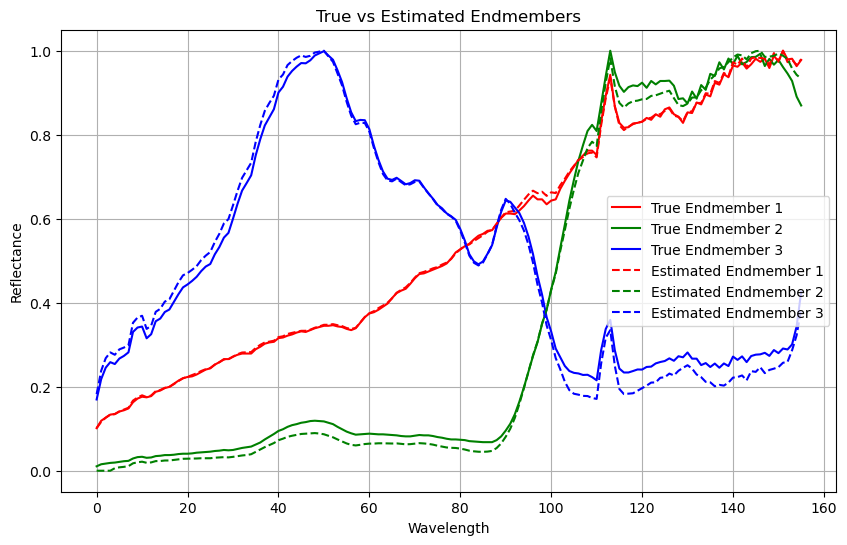

In [4]:
A = torch.from_numpy(hsi.get_abundances()).float()      # ground-truth abundances
E = torch.from_numpy(hsi.endmembers).float()            # ground-truth endmembers
E_np = np.array(E)

def align_endmembers(E, E_h):
    """
    Aligns the learned endmembers E_h with the ground truth E by testing all possible permutations.
    """
    n_sources = E.shape[0]
    best_perm = None
    best_error = float('inf')
    
    for perm in itertools.permutations(range(n_sources)):
        E_perm = E_h[list(perm), :]
        error = torch.norm(torch.tensor(E) - torch.tensor(E_perm)).item()
        if error < best_error:
            best_error = error
            best_perm = perm
    
    return E_h[list(best_perm), :], best_perm, best_error

import itertools

emd1 = vae.decode(torch.tensor([1, 0, 0], dtype=torch.float, device=device).unsqueeze(0)).cpu().detach().numpy()
emd2 = vae.decode(torch.tensor([0, 1, 0], dtype=torch.float, device=device).unsqueeze(0)).cpu().detach().numpy()
emd3 = vae.decode(torch.tensor([0, 0, 1], dtype=torch.float, device=device).unsqueeze(0)).cpu().detach().numpy()

#normalize
emd1 = emd1 / np.max(emd1)
emd2 = emd2 / np.max(emd2)
emd3 = emd3 / np.max(emd3)

E_h=np.vstack([emd1, emd2, emd3]).squeeze()

E_h_aligned, best_perm, best_error = align_endmembers(E_np, E_h)

plt.figure(figsize=(10, 6))
plt.plot(range(156),E_np[0], label='True Endmember 1', color='r')
plt.plot(range(156),E_np[1], label='True Endmember 2', color='g')
plt.plot(range(156),E_np[2], label='True Endmember 3', color='b')
plt.plot(range(156),E_h_aligned[0], label='Estimated Endmember 1', linestyle='dashed', color='r')
plt.plot(range(156),E_h_aligned[1], label='Estimated Endmember 2', linestyle='dashed', color='g')
plt.plot(range(156),E_h_aligned[2], label='Estimated Endmember 3', linestyle='dashed', color='b')
plt.legend()
plt.grid()
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.title('True vs Estimated Endmembers')
plt.show()

/var/folders/2w/rx5dw8494bg175k6ql3n37dw0000gn/T/ipykernel_55164/1795024583.py:95: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1735112947514/work/aten/src/ATen/native/TensorShape.cpp:3687.)
  A_pred_maps.T,


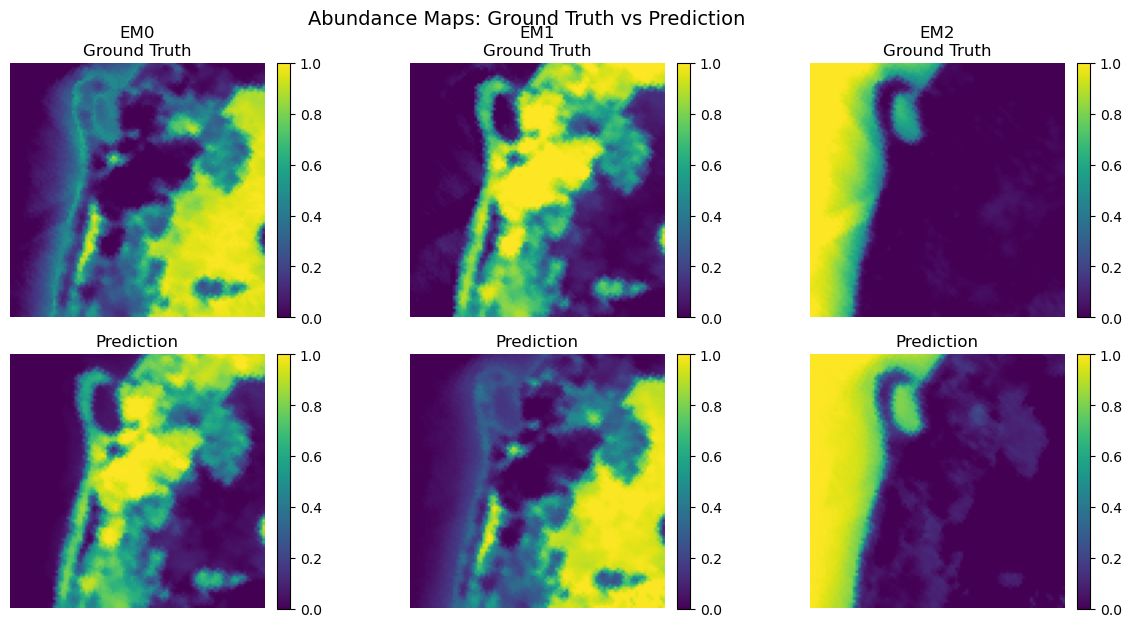

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def _as_maps(A: torch.Tensor, H: int=95, W: int=95) -> torch.Tensor:
    """Convert (N, S), (S, H, W) or (H, W, S) into (S, H, W)."""
    if A.dim() == 2:
        N, S = A.shape
        assert N == H * W, f"N={N} must equal H*W={H*W}"
        A_maps = A.t().contiguous().reshape(S, H, W)
    elif A.dim() == 3:
        if A.shape[0] in (H, W):  # (H, W, S)
            A_maps = A.permute(2, 0, 1).contiguous()  # → (S, H, W)
        else:
            A_maps = A
    else:
        raise ValueError("A must be (N,S), (S,H,W), or (H,W,S)")
    return torch.clamp(A_maps, 0.0, 1.0)


@torch.no_grad()
def predict_abundances(vae, X: torch.Tensor, device="cuda"):
    """Return predicted abundances (N, S) from trained VAE, with indices 0↔1 swapped."""
    vae.eval()
    Xd = X.to(device).float()
    _, _, abund = vae(Xd)
    abund = torch.clamp(abund, min=1e-8)
    abund = abund / abund.sum(dim=1, keepdim=True)

    # --- Swap indices 0 and 1 ---
    if abund.shape[1] >= 2:
        abund_swapped = abund.clone()
        abund_swapped[:, 1], abund_swapped[:, 2] = abund[:, 2], abund[:, 1]
        abund = abund_swapped


    return abund.detach().cpu()


def plot_abundance_comparison(A_gt_maps: torch.Tensor,
                              A_pred_maps: torch.Tensor,
                              titles=None, suptitle=None):
    """Plot ground-truth and predicted abundance maps."""
    if A_gt_maps.shape[0] != A_pred_maps.shape[0]:
        if A_pred_maps.shape[-1] == A_gt_maps.shape[0]:
            A_pred_maps = A_pred_maps.permute(2, 0, 1).contiguous()
        else:
            raise ValueError(f"Shape mismatch: A_gt={A_gt_maps.shape}, A_pred={A_pred_maps.shape}")

    A_gt_maps = A_gt_maps.float().cpu()
    A_pred_maps = A_pred_maps.float().cpu()
    S, H, W = A_gt_maps.shape

    if titles is None:
        titles = [f"Source {i+1}" for i in range(S)]

    fig, axes = plt.subplots(2, S, figsize=(4*S, 6), constrained_layout=True)
    if S == 1:
        axes = np.array(axes).reshape(2, 1)

    vmin, vmax = 0.0, 1.0

    for s in range(S):
        im0 = axes[0, s].imshow(A_gt_maps[s], vmin=vmin, vmax=vmax)
        axes[0, s].set_title(f"{titles[s]}\nGround Truth")
        axes[0, s].axis("off")
        fig.colorbar(im0, ax=axes[0, s], fraction=0.046, pad=0.04)

        im1 = axes[1, s].imshow(A_pred_maps[s], vmin=vmin, vmax=vmax)
        axes[1, s].set_title("Prediction")
        axes[1, s].axis("off")
        fig.colorbar(im1, ax=axes[1, s], fraction=0.046, pad=0.04)

    if suptitle:
        fig.suptitle(suptitle, y=1.02, fontsize=14)
    plt.show()


# --- Example usage ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vae.to(device)

# 1) Predictions
X = data
A_pred = predict_abundances(vae, X, device=device)  # (N, S)
H, W = 95, 95

# 2) Reshape for display
A_gt_maps = _as_maps(A, H, W)         # (S, H, W)
A_pred_maps = _as_maps(A_pred, H, W)  # (S, H, W)

# 3) Plot
plot_abundance_comparison(
    A_gt_maps,
    A_pred_maps.T,
    titles=[f"EM{i}" for i in range(A_pred.shape[1])],
    suptitle="Abundance Maps: Ground Truth vs Prediction"
)


# Evaluation

In [10]:
from model import VAE
from trainer import train_vae
import torch

device = torch.device("cpu")
vae = VAE(nb_channels=156, n_sources=3)
vae.load_state_dict(torch.load("vae_weights.pth", map_location=device))
vae.to(device)
vae.eval()

/var/folders/2w/rx5dw8494bg175k6ql3n37dw0000gn/T/ipykernel_55164/457613654.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("vae_weights.pt

VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=156, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.1, inplace=False)
    )
  )
  (alpha_head): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=3, bias=True)
    (4): Softplus(beta=1.0, threshold=20.0)
  )
)

In [ ]:
# --- Load HSI and tensors ---
hsi, _, _ = load_HSI(file_path)
data = torch.from_numpy(hsi.get_spectra()).float()  # shape: (N_pixels, nb_channels)
A = torch.from_numpy(hsi.get_abundances()).float()      # ground-truth abundances
E = torch.from_numpy(hsi.endmembers).float()            # ground-truth endmembers
E_np = np.array(E)

print(f"Loaded HSI from: {file_path}")
print(f"Spectra shape: {data.shape}")

# Build dataset directly from the tensor (no numpy round-trip needed)
dataset = TensorDataset(data)

# For notebook/macOS, num_workers=0 is often safer; shuffle=False for test
test_loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    drop_last=False
)

# Make sure the model is on the same device and in eval mode
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device).eval()


Loaded HSI from: ./dataset/Samson.mat
Spectra shape: torch.Size([9025, 156])


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from itertools import permutations

# -----------------------------
# 1) Reconstruction quality: MSE
# -----------------------------
@torch.no_grad()
def evaluate_mse(vae, data_loader, device):
    vae.eval()
    total_mse, n_samples = 0.0, 0
    for (batch,) in data_loader:      # TensorDataset(tensor) yields 1-tuple
        batch = batch.to(device)
        recon, alpha, abund = vae(batch)   # adapt if your forward returns a different tuple
        mse = F.mse_loss(recon, batch, reduction='sum')  # sum over batch, average at the end
        total_mse += mse.item()
        n_samples += batch.numel()
    return total_mse / n_samples      # MSE averaged over all pixels × bands

# --------------------------------------------
# 2) Endmember similarity (cosine & SAD) with alignment
# --------------------------------------------
def _cosine_similarity_matrix(A, B, eps=1e-8):
    """
    A: (k, C) estimated endmembers
    B: (k, C) reference endmembers
    returns S: (k, k) where S[i,j] = cos_sim(A[i], B[j])
    """
    A_n = A / (np.linalg.norm(A, axis=1, keepdims=True) + eps)
    B_n = B / (np.linalg.norm(B, axis=1, keepdims=True) + eps)
    return A_n @ B_n.T

def _spectral_angle(a, b, eps=1e-8):
    # returns angle in degrees
    num = np.dot(a, b)
    den = (np.linalg.norm(a) * np.linalg.norm(b) + eps)
    cosv = np.clip(num / den, -1.0, 1.0)
    return np.degrees(np.arccos(cosv))

def align_endmembers_by_cosine(E_est, E_ref):
    """
    Brute-force alignment by maximizing total cosine similarity.
    E_est, E_ref: (k, C) numpy arrays
    Returns:
      E_est_aligned, perm, per_endmember_metrics
    """
    k = E_est.shape[0]
    S = _cosine_similarity_matrix(E_est, E_ref)  # (k, k)
    best_perm, best_score = None, -np.inf
    for p in permutations(range(k)):
        score = sum(S[i, p[i]] for i in range(k))
        if score > best_score:
            best_score = score
            best_perm = p
    E_est_aligned = E_est[list(best_perm), :]

    per_endmember = []
    for i in range(k):
        cos_sim = S[i, best_perm[i]]
        sad = _spectral_angle(E_est[i], E_ref[best_perm[i]])
        per_endmember.append({"match": (i, best_perm[i]), "cosine": float(cos_sim), "SAD_deg": float(sad)})
    return E_est_aligned, best_perm, per_endmember

def evaluate_endmember_similarity(vae_endmembers, reference_endmembers):
    """
    vae_endmembers: torch.Tensor (k, C) or np.ndarray
    reference_endmembers: np.ndarray (k, C)
    Returns aggregate + per-EM stats.
    """
    E_est = vae_endmembers.detach().cpu().numpy() if isinstance(vae_endmembers, torch.Tensor) else np.asarray(vae_endmembers)
    E_ref = np.asarray(reference_endmembers)
    assert E_est.shape == E_ref.shape, f"Shape mismatch: {E_est.shape} vs {E_ref.shape}"

    E_est_aligned, perm, per_em = align_endmembers_by_cosine(E_est, E_ref)
    mean_cos = float(np.mean([d["cosine"] for d in per_em]))
    mean_sad = float(np.mean([d["SAD_deg"] for d in per_em]))
    return {
        "mean_cosine": mean_cos,
        "mean_SAD_deg": mean_sad,
        "per_endmember": per_em,
        "perm_est_to_ref": perm,
        "E_est_aligned": E_est_aligned
    }

# --------------------------------------------------
# 3) Spatial coherence of abundance maps (Total Variation)
# --------------------------------------------------
def total_variation_isotropic(img):
    """
    img: 2D array (H, W)
    TV = sum over pixels of sqrt((dx)^2 + (dy)^2)
    """
    dx = np.diff(img, axis=1)
    dy = np.diff(img, axis=0)
    tv = np.sum(np.sqrt(np.pad(dx**2, ((0,0),(0,1))) + np.pad(dy**2, ((0,1),(0,0)))))
    return float(tv)

def evaluate_spatial_coherence(abundances, rows, cols, normalize=True):
    """
    abundances: torch.Tensor or np.ndarray of shape (N_pixels, k)
    rows, cols: image spatial dimensions with rows*cols == N_pixels
    Returns per-source TV and mean TV. Lower is smoother (more coherent).
    If normalize=True, TV is divided by (rows*cols) for scale invariance.
    """
    A = abundances.detach().cpu().numpy() if isinstance(abundances, torch.Tensor) else np.asarray(abundances)
    N, k = A.shape
    assert N == rows*cols, f"rows*cols={rows*cols} must match N={N}"

    tvs = []
    for s in range(k):
        amap = A[:, s].reshape(rows, cols)
        tv = total_variation_isotropic(amap)
        if normalize:
            tv /= (rows * cols)
        tvs.append(tv)
    return {"TV_per_source": tvs, "TV_mean": float(np.mean(tvs))}


@torch.no_grad()
def evaluate_all(vae, test_loader, device, E_ref, rows, cols):
    # 1) MSE
    mse = evaluate_mse(vae, test_loader, device)

    # 2) Endmembers similarity
    em_stats = evaluate_endmember_similarity(vae.endmembers, E_ref)

    # 3) Spatial coherence of abundances
    #    We need to pass once through the data to collect abundances.
    vae.eval()
    all_abund = []
    for (batch,) in test_loader:
        batch = batch.to(device)
        recon, alpha, abund = vae(batch)  # abund: (B, k)
        all_abund.append(abund.detach().cpu())
    all_abund = torch.cat(all_abund, dim=0)  # (N_pixels, k)

    spatial_stats = evaluate_spatial_coherence(all_abund, rows=rows, cols=cols, normalize=True)

    return {
        "MSE": mse,
        "Endmembers": em_stats,
        "SpatialCoherence": spatial_stats
    }


In [15]:
# --- Ground-truth from your HSI object ---
A_gt   = torch.from_numpy(hsi.get_abundances()).float()   # (rows*cols, n_sources)
E_ref  = np.asarray(hsi.endmembers, dtype=np.float32)     # (n_sources, nb_channels)

rows, cols = hsi.rows, hsi.cols
print(f"A_gt shape: {A_gt.shape}, E_ref shape: {E_ref.shape}, image: {rows}x{cols}")

# --- Build a simple test loader from the spectra ---
data = torch.from_numpy(hsi.get_spectra()).float()        # (rows*cols, nb_channels)
test_loader = DataLoader(TensorDataset(data), batch_size=32, shuffle=False, num_workers=0)

# --- Device + model ---
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device).eval()

# --- (Optional) sanity checks on shapes ---
k = E_ref.shape[0]                           # n_sources
C = E_ref.shape[1]                           # nb_channels
assert vae.endmembers.shape == (k, C), f"Model endmembers {tuple(vae.endmembers.shape)} vs ref {E_ref.shape}"
assert data.shape[0] == rows*cols, "rows*cols must equal number of spectra (pixels)"

# --- Run the evaluation (functions from previous message) ---
results = evaluate_all(vae, test_loader, device, E_ref, rows, cols)

# --- Pretty print ---
print("\n=== Reconstruction ===")
print(f"MSE (all pixels × bands): {results['MSE']:.6e}")

print("\n=== Endmember similarity (aligned) ===")
print(f"Mean cosine: {results['Endmembers']['mean_cosine']:.6f}")
print(f"Mean SAD (deg): {results['Endmembers']['mean_SAD_deg']:.4f}")
for d in results['Endmembers']['per_endmember']:
    i_est, j_ref = d['match']
    print(f"  E_est[{i_est}] ↔ E_ref[{j_ref}]  |  cosine={d['cosine']:.6f}, SAD={d['SAD_deg']:.3f}°")
print(f"Permutation (est→ref): {results['Endmembers']['perm_est_to_ref']}")

print("\n=== Spatial coherence of abundance maps ===")
tv_mean = results['SpatialCoherence']['TV_mean']
tv_list = results['SpatialCoherence']['TV_per_source']
print(f"TV mean (lower is smoother): {tv_mean:.6e}")
for s, v in enumerate(tv_list):
    print(f"  TV[source {s}]: {v:.6e}")


A_gt shape: torch.Size([9025, 3]), E_ref shape: (3, 156), image: 95x95

=== Reconstruction ===
MSE (all pixels × bands): 4.854509e-03

=== Endmember similarity (aligned) ===
Mean cosine: 0.999283
Mean SAD (deg): 1.8902
  E_est[0] ↔ E_ref[1]  |  cosine=0.999226, SAD=2.254°
  E_est[1] ↔ E_ref[2]  |  cosine=0.998653, SAD=2.974°
  E_est[2] ↔ E_ref[0]  |  cosine=0.999970, SAD=0.443°
Permutation (est→ref): (1, 2, 0)

=== Spatial coherence of abundance maps ===
TV mean (lower is smoother): 4.694111e-02
  TV[source 0]: 6.063251e-02
  TV[source 1]: 2.603295e-02
  TV[source 2]: 5.415786e-02
